In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import statsmodels.nonparametric.api as smnp
from sklearn.linear_model import LinearRegression

from scipy.stats import norm
Z = norm.ppf

In [2]:
rencode=pd.read_csv('rencode_cxtlocBEHAVEeeg.csv', header=0, usecols=['sub', 'cond', 'cxtcond', 'old/new', 'recog_answer', 'refresh_medsplit',
       'recog confidence', 'refresh dist', 'loc1_x', 'loc1_y', 'loc2_x', 'loc2_y', 'refreshRT', 'refresh_order',
       'block', 'old/newRT', 'confidence RT'])
rencode['old/new'].unique()

array(['old', 'new'], dtype=object)

In [3]:
rencode['cxtcond']=cxt=rencode['cxtcond'].map({'cxtA':0, 'cxtB':1})
rencode['old/new']=rencode['old/new'].map({'old':0, 'new':1})
rencode['recog_answer']=rencode['recog_answer'].map({'old resp':0, 'new resp':1})
rencode['refresh_medsplit']=rencode['refresh_medsplit'].map({'close':0, 'far':1})
rencode['recog confidence']=rencode['recog confidence'].map({'low':0, 'medium':1, 'high':2})
rencode['cond']=rencode['cond'].map({'active':0, 'passive':1})
rencode['accuracy']=rencode['old/new']==rencode['recog_answer']
rencode['accuracy']=rencode['accuracy'].map({False:0, True:1})

In [4]:
old=rencode[rencode['old/new']==0]
new=rencode[rencode['old/new']==1]

In [5]:
old_means=pd.DataFrame(old.groupby(['sub', 'cond', 'cxtcond', 'recog confidence'])['accuracy'].mean())
old_means.reset_index(inplace=True)

In [6]:
old_count=pd.DataFrame(old.groupby(['sub', 'cond', 'cxtcond', 'recog confidence'])['accuracy'].count())
old_count.reset_index(inplace=True)


In [7]:
new_means=pd.DataFrame(new.groupby(['sub', 'cond', 'cxtcond', 'recog confidence'])['accuracy'].mean())
new_means.reset_index(inplace=True)
new_means

def fa(x):
    return 1-x

new_means['fa']=new_means['accuracy'].apply(fa)

In [8]:
new_count=pd.DataFrame(new.groupby(['sub', 'cond', 'cxtcond', 'recog confidence'])['accuracy'].count())
new_count.reset_index(inplace=True)

In [9]:
old_means.set_index('sub', inplace=True)
new_means.set_index('sub', inplace=True)
old_count.set_index('sub', inplace=True)
new_count.set_index('sub', inplace=True)

In [10]:
old_means=old_means[old_means['recog confidence']==2]
new_means=new_means[new_means['recog confidence']==2]
old_high=old_count[old_count['recog confidence']==2]
new_high=new_count[new_count['recog confidence']==2]
old_means.shape

(96, 4)

In [11]:
old_means.drop(index=722, inplace=True)
new_means.drop(index=722, inplace=True)
old_high.drop(index=722, inplace=True)
new_high.drop(index=722, inplace=True)
old_means.shape

/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(92, 4)

In [12]:
old_high.rename(columns={'accuracy':'old_count'}, inplace=True)
new_high.rename(columns={'accuracy':'new_count'}, inplace=True)

/Users/drdj/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [13]:
old_means.rename(columns={'recog confidence':'conf', 'accuracy':'hit'}, inplace=True)

new_tmp=new_means[['fa']]
old_count=old_high[['old_count']]
new_count=new_high[['new_count']]
old_new_means=pd.concat([old_means, new_tmp, old_count, new_count], axis=1)

In [14]:
old_new_means.drop(index=707, inplace=True)
old_new_means.drop(index=724, inplace=True)

old_new_means.reset_index(inplace=True)

In [15]:
for ind, row in old_new_means.iterrows():
    halfhit=.5/row['old_count']
    halffa=.5/row['new_count']
    hit=row['hit']
    fa=row['fa']
    if hit==1:
        hit=1-halfhit
    if hit==0:
        hit=halfhit
    if fa==1:
        fa=1-halffa
    if fa==0:
        fa=halffa
    dprime=Z(hit)-Z(fa)    
    old_new_means.loc[ind,'adjusted_hit']=hit
    old_new_means.loc[ind,'adjusted_fa']=fa
    old_new_means.loc[ind,'dprime']=dprime


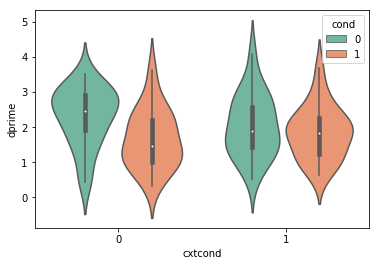

In [16]:
sns.violinplot(x='cxtcond', y='dprime', hue='cond', data=old_new_means, palette='Set2')

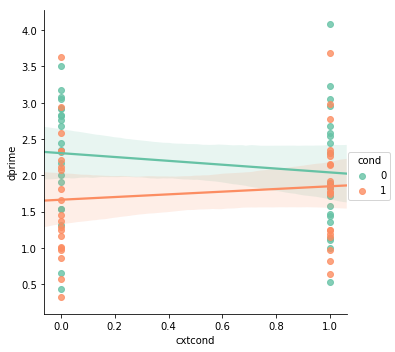

In [19]:
sns.lmplot(x='cxtcond', y='dprime', hue='cond', data=old_new_means, palette='Set2')

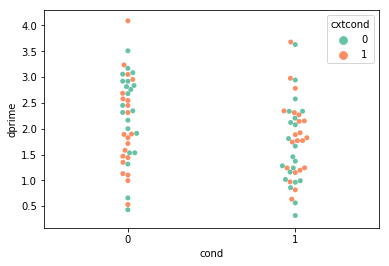

In [18]:
sns.swarmplot(x='cond', y='dprime', hue='cxtcond', data=old_new_means, palette='Set2')